<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/Churn_prediction_AUCmetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load the CSV from GitHub
url = "https://raw.githubusercontent.com/selva86/datasets/master/Churn_Modelling.csv"
df = pd.read_csv(url)
# Display first few rows
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.drop_duplicates(inplace=True)

In [11]:
df=df.drop(axis=1, columns=['RowNumber',	'CustomerId',	'Surname'])

In [12]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


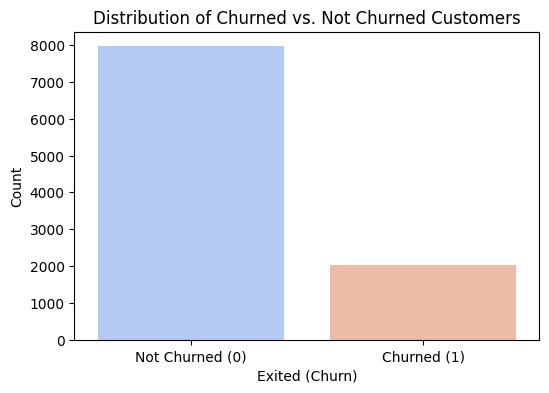

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each class (0 = Not Churned, 1 = Churned)
churn_counts = df["Exited"].value_counts()

# Plot the distribution
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, hue=churn_counts.index, legend=False, palette="coolwarm")

# Add labels
plt.xlabel("Exited (Churn)")
plt.ylabel("Count")
plt.title("Distribution of Churned vs. Not Churned Customers")
plt.xticks([0,1], ["Not Churned (0)", "Churned (1)"])
plt.show()


### it is an imbalanced datset - so use Class Weights in the Model. Many ML models support class weights to penalize misclassification of the minority class.

In [7]:
from sklearn.utils.class_weight import compute_class_weight

check for outliers:

In [13]:
# Separate categorical and numerical features
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numerical_features = df.select_dtypes(include=["int", "float"]).columns.tolist()

# Remove the target variable "Exited" from numerical features
numerical_features.remove("Exited")

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


Categorical Features: ['Geography', 'Gender']
Numerical Features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


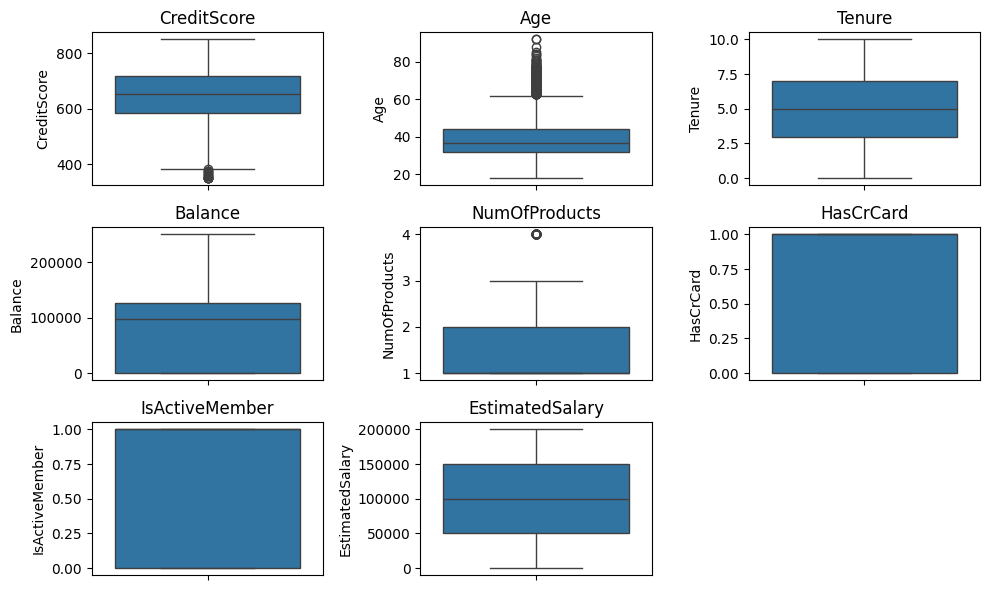

In [17]:
# Plot box plots for each numerical feature
plt.figure(figsize=(10, 6))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)  # Adjust grid size based on number of features
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


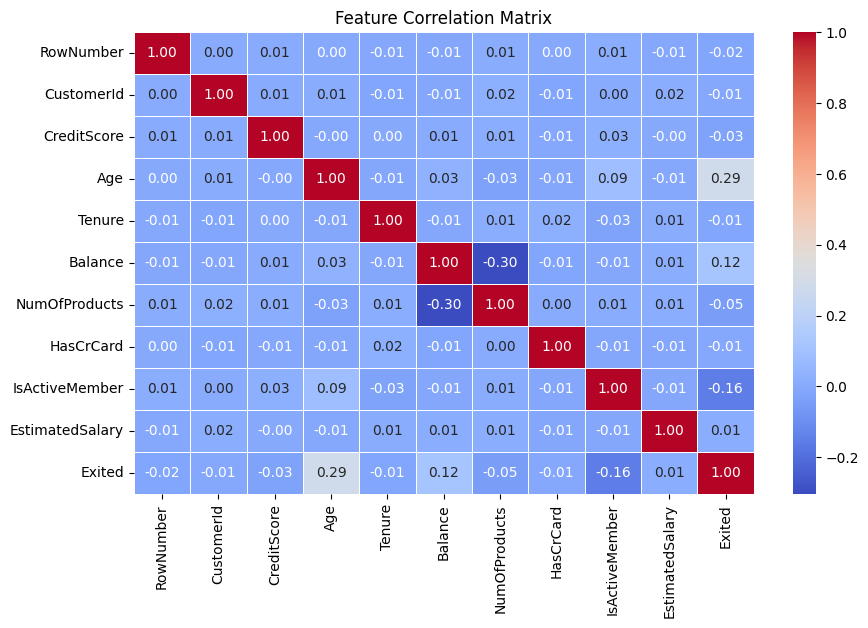

In [8]:
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

### not much correlation (+ve or -ve) between features

In [18]:
# Count unique values in each categorical feature
for col in categorical_features:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].unique())  # Show actual unique values
    print("-" * 40)


Geography: 3 unique values
['France' 'Spain' 'Germany']
----------------------------------------
Gender: 2 unique values
['Female' 'Male']
----------------------------------------


encode Categorical features and scale Numerical Features

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.538,France,Female,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1
1,0.516,Spain,Female,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0
2,0.304,France,Female,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1
3,0.698,France,Female,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0
4,1.000,Spain,Female,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0


In [21]:
from sklearn.preprocessing import OneHotEncoder

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1,False,False,False
1,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0,False,True,False
2,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1,False,False,False
3,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,0,False,False,False
4,1.000,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0,False,True,False


In [22]:
from sklearn.model_selection import train_test_split

# Features (X) and Target (y)
X = df.drop(columns=["Exited"])
y = df["Exited"]

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (8000, 11), Test shape: (2000, 11)


# Logistic regression without balanced dataset

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

# Initialize the Logistic Regression model with regularization (C is the inverse of regularization strength)
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)

# Perform Cross-validation (5-fold)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

# Print Cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean():.4f}")


Cross-validation scores: [0.74852594 0.7584316  0.77668064 0.74807908 0.7739831 ]
Average cross-validation score: 0.7611


In [37]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for `C` (regularization strength)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Search for values of `C`
grid_search = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42, max_iter=1000),
                           param_grid, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

# Print best hyperparameter and score
print(f"Best hyperparameter (C): {grid_search.best_params_['C']}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best hyperparameter (C): 100
Best cross-validation score: 0.7619


Test AUC score: 0.7789


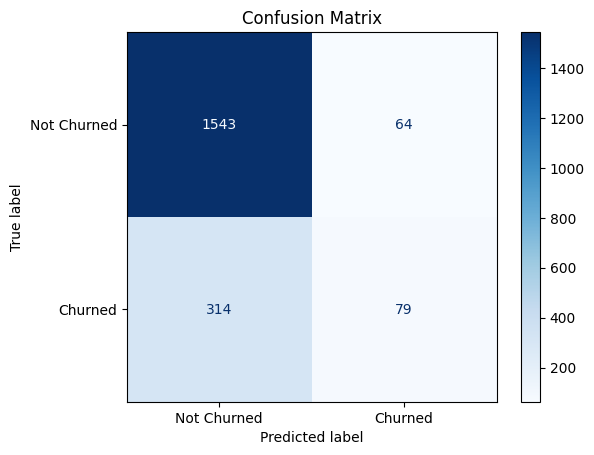

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Train the model on the full training data with the best regularization strength (C)
best_model = grid_search.best_estimator_
# Predict probabilities on the test set
y_probs = best_model.predict_proba(X_test)[:, 1]  # Get probability for the positive class (1)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"Test AUC score: {auc_score:.4f}")

# Predict class labels on the test set
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Logistic regression with balanced dataset

Test AUC score with SMOTE: 0.7817


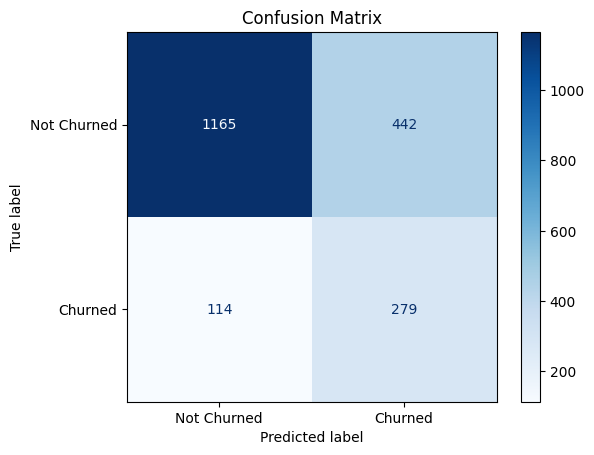

In [42]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000, class_weight='balanced')

# Train the model on the balanced training data
model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities on the test set
y_probs = model.predict_proba(X_test)[:, 1]  # Get probability for the positive class (1)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"Test AUC score with SMOTE: {auc_score:.4f}")

# Predict class labels on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# Ensemble based methods

Random Forest AUC: 0.8647


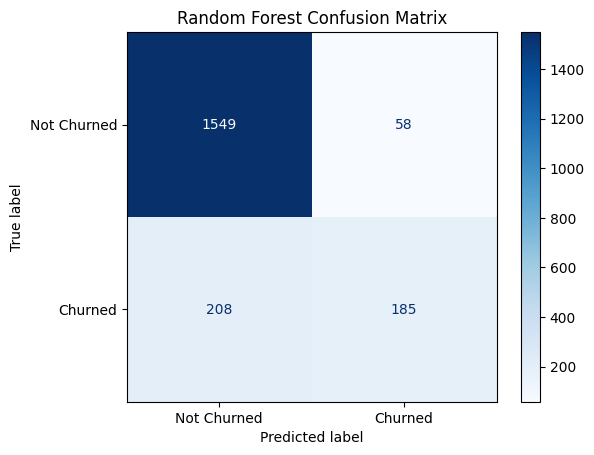

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute the AUC score for Random Forest
auc_rf = roc_auc_score(y_test, y_probs_rf)
print(f"Random Forest AUC: {auc_rf:.4f}")

# Predict class labels on the test set
y_pred_rf = rf_model.predict(X_test)

# Compute confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['Not Churned', 'Churned'])
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()


Random Forest AUC: 0.8494


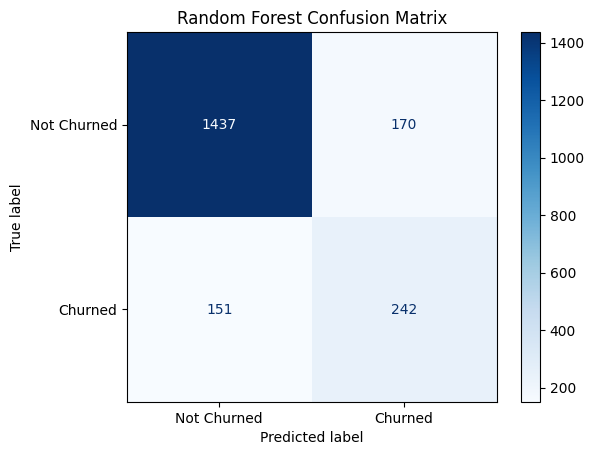

In [44]:
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities on the test set
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute the AUC score for Random Forest
auc_rf = roc_auc_score(y_test, y_probs_rf)
print(f"Random Forest AUC: {auc_rf:.4f}")

# Predict class labels on the test set
y_pred_rf = rf_model.predict(X_test)

# Compute confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['Not Churned', 'Churned'])
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()


# GradientBoostingClassifier

Gradient Boosting AUC: 0.8729


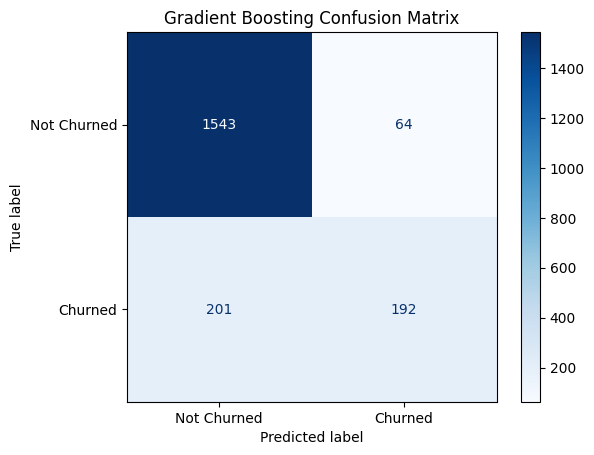

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_probs_gb = gb_model.predict_proba(X_test)[:, 1]

# Compute the AUC score for Gradient Boosting
auc_gb = roc_auc_score(y_test, y_probs_gb)
print(f"Gradient Boosting AUC: {auc_gb:.4f}")

# Predict class labels on the test set
y_pred_gb = gb_model.predict(X_test)

# Compute confusion matrix for Gradient Boosting
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb, display_labels=['Not Churned', 'Churned'])
disp_gb.plot(cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


Gradient Boosting AUC: 0.8658


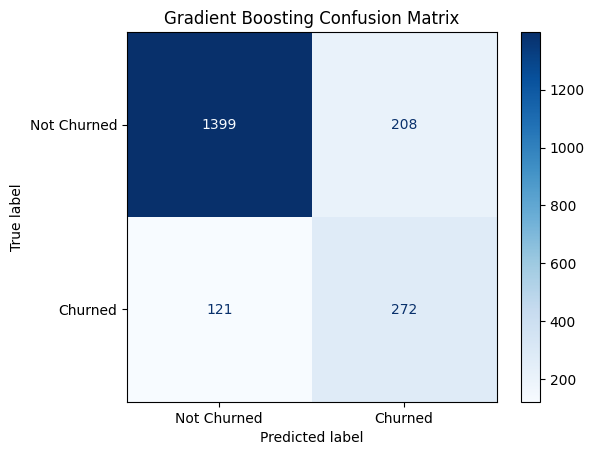

In [46]:
gb_model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities on the test set
y_probs_gb = gb_model.predict_proba(X_test)[:, 1]

# Compute the AUC score for Gradient Boosting
auc_gb = roc_auc_score(y_test, y_probs_gb)
print(f"Gradient Boosting AUC: {auc_gb:.4f}")

# Predict class labels on the test set
y_pred_gb = gb_model.predict(X_test)

# Compute confusion matrix for Gradient Boosting
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb, display_labels=['Not Churned', 'Churned'])
disp_gb.plot(cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()


# Stacking classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

# Base models
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Meta-model
meta_model = LogisticRegression(solver='liblinear', random_state=42)

# Initialize Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_model)

# Train the Stacking Classifier
stacking_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_probs_stacking = stacking_clf.predict_proba(X_test)[:, 1]

# Compute the AUC score for Stacking Classifier
auc_stacking = roc_auc_score(y_test, y_probs_stacking)
print(f"Stacking Classifier AUC: {auc_stacking:.4f}")

# Predict class labels on the test set
y_pred_stacking = stacking_clf.predict(X_test)

# Compute confusion matrix for the Stacking Classifier
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
disp_stacking = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_stacking, display_labels=['Not Churned', 'Churned'])
disp_stacking.plot(cmap='Blues')
plt.title("Stacking Classifier Confusion Matrix")
plt.show()


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(scale_pos_weight=4, random_state=42)  # 8000/2000 = 4
